
# Künstlicher Assistent für die Annotation des Märchens

## Google Colab Arbeitplatz vorbereiten

In [ ]:
!git clone https://github.com/edadunashvili/Monographie.git

In [ ]:
cd /content/Monographie

In [ ]:
!pip install scikit-learn==1.1

In [ ]:
!pip install mglearn

In [ ]:
!pip install --upgrade joblib==1.1.1

In [131]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Aggregation des Korpus von Trainingsdaten 

[Zelle # 1]

1-3: Die Variable 'tupNum', 'repert' und 'ausnahme' gelten für die Auswahl der in dem Trainingsdatenrepositorium angelegte Texte mit dem gesuchten Typ und dem Herkunftsrepertoire. Sowohl die Variable 'typNum' ails auch 'repert' kann mit leeren Anführungszeichen dargestellt werden, für die Variable 'ausnahme' ist entweder ein unwahrscheinlicher Wert (z.B. 'xxyyzz') oder der Wert womit man eine bestimmte Gruppe  von Daten aus der Wahl ausschließen kann eine Pflicht.

4-8: Jedes Mal bei der Aggregation des Korpus von Trainingsdaten wird der gleichnamige alte Korpus gelöscht.


In [310]:
typNum='300'
repert=''
ausnahme='xxyyzz'
def entfernen(var):
    import os
    if os.path.exists(var):
        os.remove(var)
entfernen('episode_binar_train.csv')

[Zelle # 2]

1-59: Aggregation der Datei 'episode_temp_train.csv' (eine Funktion). Die im Ordner „Trainingsdaten“ angelegte TXT Dateien werden in der CSV Datei aggregiert und in das root Repositorium verlegt.

60-66: Umwandlung 'episode_temp_train.csv' in die Datei 'episode_string_train.csv'.

67-72: 'episode_string_train.csv' laden, von den überflüssigen Zeichen bereinigen und ins Trainingsdatenkorpus 'episode_binar_train.csv' umwandeln.

ab-73: Unnotige Aggregationen werden gelöscht.

In [311]:
def clean(line):
    line = line.replace("\n"," ").strip()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe")
    line = line.replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","")
    line = line.replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a")
    line = line.replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ")
    line = line.replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ")
    line = line.replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','')
    line = line.replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    for i, _ in enumerate(line):
        if (i !=0) and (i!=2):
            line[i]=line[i].lower()
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret
def write_back(words, temp):
    with open(temp, "a", encoding='utf-8') as output:      
        for word in words:
            as_lex = word[0]
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)
def aggreg(temp, ordner):
    import glob
    with open(temp, "w", encoding='utf-8') as output:
        output.write ("quelle,episode,index_string,index_binar\n")
    sorted_files=sorted(glob.glob(ordner))
    pairs = []
    for file in sorted_files:
        if typNum in file and repert in file and not ausnahme in file:
            with open(file, 'r', encoding='utf-8', errors='ignore') as episode:
                for line in episode.readlines():
                    clean_words = clean(line)
                    pairs = pairs + clean_words
    write_back(pairs, temp)
temp = "episode_temp_train.csv"
ordner = "Trainingsdaten/*.txt"
aggreg(temp, ordner)
fin = open('episode_temp_train.csv','r', encoding ='utf-8')
fout = open('episode_string_train.csv', "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"")
               .replace("', '", "','").replace(" '", "'"))
fin.close()
fout.close()
fin = open('episode_string_train.csv','r', encoding='utf-8') 
fout = open('episode_binar_train.csv', "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))             
fin.close()
fout.close()
entfernen('episode_temp_train.csv')
entfernen('episode_string_train.csv')

##  Herstellung des Modells und der prototypischen Metaepisode 

[Zelle # 3]

1-5: Trainingdatenkorpus zugreiffen und der im Datenfeld 'index_string' eingetragene Merkmalen mitsamt der Vorkommenshäufigkeitsrate einbelden.

In [312]:
import pandas as pd
from collections import Counter
df = pd.read_csv('episode_binar_train.csv',  encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({'e300_e_vorfeld_des_kampfes_bis_zum_sieg': 41, 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not': 36, 'e300_o_auftritt_des_HD_vor_dem_AG_bis_zur_erkennung_seiner_heldentat': 34, 'e300_g_nach_dem_sieg_bis_zur_trennung_des_HD_und_des_OB': 29, 'e300_k_misshandlung_des_FH_bis_zur_hochzeit': 27, 'e300_m_rueckkehr_des_HD_und_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit': 18, 'e303_c_eingangssituation_bis_zur_trennung': 18, 'eUNDF_a_': 16, 'e303_g_erstes_treffen_mit_dem_AN': 16, 'e303_i_von_der_erkundigung_der_not_bis_zum_aufbruch_des_HF_zum_AN': 15, 'e303_k_vom_aufbruch_zum_AN_bis_zum_sieg_ueber_ihn': 15, 'e554_e_leistung_des_HD_gegenueber_dem_tier_und_aussprechen_der_dankbarkeit': 12, 'e315_a_': 12, 'eCoM_c_conceptia_magica': 11, 'e300_l_wiederbelebung_des_HD': 9, 'e300_i_rueckkehr_des_OB_und_die_suche_nach_dem_HD': 7, 'e300_q_von_der_begegnung_mit_dem_vogel_bis_zum_ende_des_fluges': 7, 'e550_a_': 7, 'e303_m_eifersucht': 5, 'e328_a_': 4, 'e303_q_ruec

[Zelle # 4]

1: In den obeneingeblendete Merkmalen eine Episode Kopieren und hier als Wert der Variable 'gesep' einfügen. 

In [313]:
gesep = 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'

[Zelle # 5]

1-6: In Trainingsdaten die gesuchte Episode ('gesep') mit Einsen (1), den Rest mit Nullen (0) etikettieren und die Änderung speichern.

In [314]:
for i, gesuchte_episode in enumerate(df.index_string):
    if (gesuchte_episode == gesep):
        df.index_binar[i]='1'
    else: 
            df.index_binar[i]='0'
df.to_csv('episode_binar_train.csv', encoding='utf-8', index=False)

[Zelle # 6]

1-4: Im Trainingsdatenkorpus die Datenfelder für Probetexte (X_train) und für die Merkmalen (y_train) bestimmen und die Bilanz zwischen negativ (0) und positiv (1) etikettierten Datensätzen betrachten ( s. Counter).

In [315]:
X_train=(df['episode'])
y_train=(df['index_binar'])
indexliste=Counter(df.index_binar)
print(indexliste, sep='\n')

Counter({'0': 349, '1': 36})


[Zelle # 7]

1: Die in die eckige Klammern eingetragene Wörter werden zusätzlich in die vorhandene Stopwörter-Liste eingefügt. Einzelnes Wort muss dabei mit Anführungszeichen umgeschlossen und von andren Wörter durch das Komma getrennt werden, ein Beispiel: ['mein','dein']. 

2-6: Datenfeld 'episode' von konwentionelen und von uns eingegebenen Stoppwörter bereinigen. 

In [316]:
custom_stop_word_list=[]
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
NLTK_stop_words_list=stopwords.words('german')
de = custom_stop_word_list + NLTK_stop_words_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elguj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[Zelle # 8]

1-8: Einrichtung einer sciki-learn Pipeline mit Klassen LogisticRegression, TfidVectorizer und GridSearchCV. 

9-10: Modell auswerten (s. Bester Score aus der Kreuzvalidierung:).

In [317]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=3, stop_words=de, ngram_range=(1,1), norm=None), 
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}     
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Bester Score aus der Kreuzvalidierung: {:.2f}".format(grid.best_score_))

Bester Score aus der Kreuzvalidierung: 0.94


[Zelle # 9]

1-6: Aus dem Modell die Liste der positiven und negativen Merkmalen extrachieren, Zahl der Merkmalen einblenden (s. Gesamte Anzahl der Wörter:).

In [318]:
import numpy as np
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
max_value = vectorizer.transform(X_train).max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names_out())
print("Gesamte Anzahl der Wörter: {}".format(len(vectorizer.vocabulary_)))

Gesamte Anzahl der Wörter: 2365


[Zelle # 10]

1-6: Merkmalen mit höchsten Koeffizienten visualisieren (blau=positiv, rot=negativ). Variable 's_zahl' stellt fest wieviel Merkmalen von beiden Kategorien eingeblendet werden muss. 

7: Gibt den genauen Wert des kleinsten und höchsten Koeffizienten zurück.

(-0.18330648247848172, 0.42363871892623584)

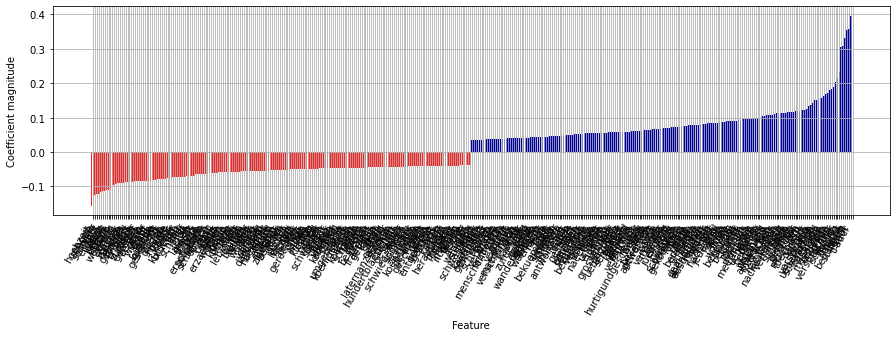

In [319]:
s_zahl = 200
import matplotlib.pyplot as plt
import mglearn
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_, 
    feature_names, n_top_features=s_zahl)
plt.grid()
#plt.loglog()
plt.ylim()
#plt.savefig(gesep+'.jpg', dpi=80)

[Zelle # 11a]

1-7: Extrahieren der Topklassifikationsmerkmalen mit positiven und negativen Werten und ihre Koefizienten.

8-11: Visualisierung der ausgewählten Merkmalen bzw. Koefizienten.

In [320]:
gio=(grid.best_estimator_.named_steps["logisticregression"].coef_[0])
n_top=np.argsort(gio)
z_top=np.sort(gio)
text_pos=feature_names[n_top[-s_zahl:]]
text_neg=feature_names[n_top[0:s_zahl]]
zahl_pos=gio[n_top[-s_zahl:]]
zahl_neg=gio[n_top[0:s_zahl]]
#print("Positive Merkmale:\n{}".format(text_pos))
#print ("Negative Merkmale:\n{}".format(text_neg))
#print ("Positive coef:\n{}".format(zahl_pos))
#print ("Negative coef:\n{}".format(zahl_neg))

 [Zelle # 11b]
 
 1-7: Berechnung des Schwellenwertes nach der Gleichung (y, x)+(-y, -x) geht die Gleichung auf 0, so ist der Schwellenwert gleich x.
 
 

In [321]:
kfz=range(s_zahl)
folgenum=0
for x in kfz:
    folgenum+=1
    vollliste=(zahl_pos[s_zahl-folgenum])+(zahl_neg[s_zahl-folgenum])
    rundliste=(round(vollliste,3))
    print(rundliste, '-', x)

0.357 - 0
0.319 - 1
0.315 - 2
0.291 - 3
0.269 - 4
0.265 - 5
0.193 - 6
0.176 - 7
0.164 - 8
0.149 - 9
0.145 - 10
0.142 - 11
0.132 - 12
0.127 - 13
0.123 - 14
0.118 - 15
0.117 - 16
0.114 - 17
0.112 - 18
0.111 - 19
0.101 - 20
0.095 - 21
0.093 - 22
0.083 - 23
0.081 - 24
0.081 - 25
0.08 - 26
0.078 - 27
0.078 - 28
0.077 - 29
0.075 - 30
0.075 - 31
0.075 - 32
0.074 - 33
0.071 - 34
0.071 - 35
0.07 - 36
0.07 - 37
0.07 - 38
0.069 - 39
0.066 - 40
0.065 - 41
0.064 - 42
0.063 - 43
0.062 - 44
0.059 - 45
0.059 - 46
0.056 - 47
0.055 - 48
0.054 - 49
0.054 - 50
0.053 - 51
0.052 - 52
0.051 - 53
0.05 - 54
0.05 - 55
0.05 - 56
0.049 - 57
0.048 - 58
0.046 - 59
0.045 - 60
0.045 - 61
0.044 - 62
0.044 - 63
0.044 - 64
0.043 - 65
0.04 - 66
0.04 - 67
0.04 - 68
0.039 - 69
0.038 - 70
0.038 - 71
0.037 - 72
0.037 - 73
0.036 - 74
0.036 - 75
0.034 - 76
0.032 - 77
0.032 - 78
0.031 - 79
0.031 - 80
0.03 - 81
0.03 - 82
0.029 - 83
0.029 - 84
0.028 - 85
0.027 - 86
0.027 - 87
0.026 - 88
0.025 - 89
0.024 - 90
0.023 - 91
0.023 - 92

[Zelle # 11c]

Schwellenwert für die Variable sw manuel eintragen.

In [322]:
sw=123

[Zelle # 12]

1-17: Bestimmte Merkmale in die neue txt Datei speichern(1-7) gesamte Information durch die Datenfelder strukturieren (8-12) und  nach dem Löschen der alten Datei (13) in Messdatenordner anlegen (14-17).

In [323]:
import csv 
import shutil, os
filename = '0_'+gesep
tit=(text_pos[s_zahl-sw:s_zahl])
with open (filename+'.txt', 'wt', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerow(tit)
with open(filename+'.txt', 'r') as file:
    file_contents = file.read().replace("\n", "")
    frt_contents = filename+'|'+file_contents+'|0|0'
with open(filename+'.txt', 'wt', encoding='utf-8') as f:
        f.write(frt_contents)
entfernen('Messdaten/'+filename+'.txt')
import glob
files = glob.glob(filename+'.txt')
for f in files:
    shutil.move(f, 'Messdaten/')

##  Herstellung des Messdatenkorpus 

[Zelle # 13]

1-3: Die Variable 'tupNum', 'repert' und 'ausnahme' gelten für die Auswahl der in dem Messdatenrepositorium angelegte Texte mit dem konkretem Typ und dem Herkunftsrepertoire. Sowohl die Variable 'typNum' ails auch 'repert' kann mit leeren Anführungszeichen dargestellt werden. Für die Variable 'ausnahme' ist entweder ein unwahrscheinlicher Wert (z.B. 'xxyyzz') oder der Wert womit man eine bestimmte Gruppe von Daten aus der Wahl ausschließen kann eine Pflicht.

4: Der vorhandene Messdaten-Korpus löschen (falls vorhanden)

5-7: In dem Messdatenordner Messdaten parsen und einen 'episode_temp_mess.csv' Korpus aggregieren.

8-16: 'episode_temp_mess.csv' von den überflussigen Zeichen bereinigen und ins  Messdatenkorpus - 'episode_binar_mess.csv' umwandeln.

17-21: Datenfelder deklarieren und Datensätzen zählen (s. Counter), anschließend unnotige Temp-Aggregation löschen.

22-29: Messdatenkopus aus den Epsoden bestimmen und alle andere Datenfelder ignorieren

In [324]:
typNum=''
repert=''
ausnahme='xxyyzz'
entfernen('episode_binar_mess.csv')
temp = "episode_temp_mess.csv"
ordner = "Messdaten/*.txt"
aggreg(temp, ordner)
from collections import Counter
fin = open("episode_temp_mess.csv",'r', encoding ='utf-8')
fout = open('episode_binar_mess.csv', "wt", encoding ='utf-8')
for efz in fin:
    fout.write(efz.replace(', "["',"").replace('"[', "")
               .replace(']"',"").replace("', '", "','")
               .replace(" '", "'").replace("'",""))   
fin.close()
fout.close()
df = pd.read_csv('episode_binar_mess.csv', encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_binar)
print(indexliste)
entfernen('episode_temp_mess.csv')
t_corpus = []
file = 'episode_binar_mess.csv'
with open(file, "r", encoding='utf-8') as maerchen:
    maerchen = df.episode
    reader = csv.reader(maerchen, delimiter = "|") 
    for row in reader:       
        lst = str(row)
        t_corpus.append(lst)

Counter({0: 105})


## Vorhersage durch LOGISTICREGRESSION

[Zelle # 14]

1-2: Vorhersage treffen.

3: Der synthetische Datensätzen wird ausgeschloßen. 

4: Jeder positiv bewerteter Datensatz wird extra eingebledet.

In [325]:
mod_pred=grid.predict(t_corpus)
for index in enumerate(mod_pred): 
    if '1' in (index) and index[0]>0:   
        print ('Positiv bewerteter Datensatz:{}'.format(index))

Positiv bewerteter Datensatz:(28, '1')


[Zelle # 15]

1-7: Alle probabilitische Vorhersagen abruffen. Durch das Manipulieren der Variable 'pos>=' in der Zeile 6 wird der minimale Score angepasst.

In [330]:
all_pred=grid.predict_proba(t_corpus) 
sort_index=np.flip(all_pred[:,1].argsort())
for num_pos in sort_index:
    pos=all_pred[num_pos][1]
    for i,t_corpus_element in enumerate(t_corpus):
        if i==num_pos  and num_pos>0 and pos>0.007:
            print(num_pos,'-', pos,'-', df.quelle[num_pos],'-', df.episode[num_pos])

28 - 0.9567407551653747 - mess_47 - dieser aber war in die stadt getreten wo er alles in bestuerzung und trauer fand alle fenster waren mit schwarzen tuechern verhangen er erkundigte sich daher was die ursache solcher trauer waere und erfuhr dass riesen in der naehe wohnten welche die stadt immer in angst und schrecken hielten und dass sieben drachen in einer nahen hoehle hausten welchen sie jeden tag einen menschen opfern muessten  und endlich sey eine schlange nicht weit auf einem baume welche alle menschen verzehre die ungluecklicher weise in ihr bereich kaemen niemand aber waere zu finden welcher die stadt von diesen ungeheuern befreyen wollte
46 - 0.2801889821027549 - mess_48 - auf dem wege zu dieser kirche stand ein wirtshaus da hinein ging der soldat und logierte sich ein auf die nacht verlangte er zu trinken da sagte die wirtin das wasser in dem brunnen sei nicht gesund sie wolle ihm zitronenwasser geben sie aber gab ihm einen schlaftrunk er ging zwar hinaus setzte sich an den 

##  Vorhersage durch die COSINE-SIMILARITY

[Zelle # 16]

1-14: Daten im Messdatenkorpus Vektorisieren, Transformieren und die Metrik für die Vorhersagefunktion definieren.

In [327]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer
vectorizers = vectorizer(analyzer='word', ngram_range=(1,1),
                         min_df = 2, stop_words = de)
vokabular =  vectorizers.fit_transform (t_corpus)
metrik = cosine_similarity
def find_similar(vokabular, index, top_n =-1):   
    metriks = metrik(vokabular[index:index+1], vokabular).flatten()
    related_docs_indices = [i for i in metriks.argsort()[::-1] 
                            if i != index]
    return [(index, metriks[index]) for index 
            in related_docs_indices][0:top_n]

[Zelle # 17]

1-3: Gesuchte Episode (Zielepisode) einblenden. Die gesuchte Episode wird wird die 'n_te'-Variable bestimmt. Manuell eingepflegte Zielepisoden sollen deshalb immer in der ersten Reihen der Korpusdatensätzen stehen. Wir empfehlen deshalb, dass diese Daten mit dem Prefix '0_' benannt wird.)

4: Synthetische Datei aus dem Messdatenordner entfernen.

In [328]:
n_te = 0
synt = t_corpus[n_te]
print(df.quelle[n_te],'-', synt)
entfernen('Messdaten/'+'0_'+gesep+'.txt')

0_e300_c_anfangssituation_ankunft_und_erkundigung_der_not - ['ueberzogen kurz schwarze wasser suchte koepfen jemand gegend weinten versuchen uhr kellner hurtigundgeschwind wellen seid weib bezahlen gefressen antwortete ort kind bestie vernahm morgen zar geben einzige juengling sollt haetten mehl schwarzen verlange gekommen lebten haus weine auge toete bedeuten gleichen halten toedte fragt demjenigen abendessen ausgeliefert haeuser haelfte koenig wirt nachricht drei jedesmal retten seien reich finde wohnte alte bekommt obwohl ass betruebt immer erste mensch dannen los muessen meermanne witwe uebrigen naehe darum herberge sei wirtshaus niemand alljaehrlich maedchen drachen loos toeten haeuschen nacheinander leute verhaengt land schoene dach frassen gefallen jungfrau flor muessten geb toechtern damals kommt ach verschlang drache uebergeben schwarzem naechste voll fragte menschen befreien erloesen grade versprochen tochter schuster warum traurig macht reihe behangen schwarz stadt trauer']


[Zelle # 18]

1-3: Suchen starten und die Ergebnisse einblenden.

In [331]:
for index, score in (find_similar(vokabular, n_te)):
    if (df.index_string[index]==0 and score>0.007):
        print(index,'-', score,'-', df.quelle[index],'-', 
           t_corpus[index], '-',  df.index_binar[index],'-', df.index_binar[index])

84 - 0.2539476080359042 - mess_46 - [' ach mein kind wir haben hier kein wasser in dieser gegend hier lebt eine lamia die das wasser unter verschluss haelt wir bekommen nichts wenn sie nicht jeden tag ein maedchen zu fressen bekommt und morgen wird sie die koenigstochter rodanthi fressen'] - 0 - 0
28 - 0.22449037884681752 - mess_47 - ['dieser aber war in die stadt getreten wo er alles in bestuerzung und trauer fand alle fenster waren mit schwarzen tuechern verhangen er erkundigte sich daher was die ursache solcher trauer waere und erfuhr dass riesen in der naehe wohnten welche die stadt immer in angst und schrecken hielten und dass sieben drachen in einer nahen hoehle hausten welchen sie jeden tag einen menschen opfern muessten  und endlich sey eine schlange nicht weit auf einem baume welche alle menschen verzehre die ungluecklicher weise in ihr bereich kaemen niemand aber waere zu finden welcher die stadt von diesen ungeheuern befreyen wollte'] - 0 - 0
17 - 0.1807851960122564 - mess_4

## Ende 